# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

# Pretty printer 
import pprint
pp = pprint.PrettyPrinter(depth=6)

# For displaying max number of lines
pd.set_option("display.max_rows", 500)

# For reproducability
SEED = 2

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
def load_avarto_data(clean = False, scaled = False):
    """
    Loads azdias, customer, attribute values and attribute information data
    
    Args:
        clean (bool): loads cleaned data, if set to True and cleaned data exists.
                Default: False
    
    Returns:
        azdias : Azdias DataFrame
        customers : Customers DataFrame
        attribute_values : Attribute values DataFrame
        attribute_info : Attribute information DataFrame
        
    """
    
    # Ignore any empty columns while loading data
    no_unamed = lambda x: 'Unnamed' not in x
    
    # Check if cleaned data exists
    clean_exists = False
    if clean:
        clean_exists = os.path.isfile("./data/Customers_cleaned.csv") & \
            os.path.isfile("./data/Azdias_cleaned.csv")
        if clean_exists:
            print("Cleaned Data Exists")
        else:
            print("Cleaned Data does not Exist!")
            
    # Check if scaled data exists
    scaled_exists = False
    if scaled:
        scaled_exists = clean_exists = os.path.isfile("./data/Customers_scaled.csv") & \
            os.path.isfile("./data/Azdias_scaled.csv")
        if scaled_exists:
            print("Scaled Data Exists")
        else:
            print("Scaled Data does not Exist!")
                
        
#     azdias = None
#     customers = None
    customers_additional = None
#     attributes_values = None
#     attributes_info = None

    if scaled and scaled_exists:
        print("Loading Scaled Azdias and Customers Data")
        azdias = pd.read_csv('./data/Azdias_scaled.csv', usecols=no_unamed)
        customers = pd.read_csv('./data/Customers_scaled.csv', usecols=no_unamed)
        customers_additional = pd.read_csv('./data/Customer_Additional_cleaned.csv', usecols=no_unamed)

    else:
        if clean_exists:
            print("Loading Cleaned Azdias and Customers Data")
            azdias = pd.read_csv('./data/Azdias_cleaned.csv', usecols=no_unamed)
            customers = pd.read_csv('./data/Customers_cleaned.csv', usecols=no_unamed)
            customers_additional = pd.read_csv('./data/Customer_Additional_cleaned.csv', usecols=no_unamed)
        else:
            print("Loading Raw Azdias and Customers Data")
            azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', usecols=no_unamed)
            customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', usecols=no_unamed)

    attributes_values = pd.read_excel('./data/DIAS Attributes - Values 2017.xlsx', header=1, usecols=no_unamed)
    attributes_info = pd.read_excel('./data/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=no_unamed)    
    
    return azdias, customers, customers_additional, attributes_values, attributes_info

In [3]:
azdias, customers, customers_additional, attributes_values, attributes_info = load_avarto_data()

Loading Raw Azdias and Customers Data


C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


The warning says columns 18 and 19 have mixed data types, we can explore these two columns in later steps. This is one point to remember.

### Checking data shapes:

Verifying whether shapes of dataframes and the extra columns that are there in the customers dataset as per the description.

In [4]:
print("Azdias shape -",azdias.shape)
print("Customers shape -",customers.shape)

Azdias shape - (891221, 366)
Customers shape - (191652, 369)


In [5]:
print("Number of columns in Customers Data - ", len(list(customers.columns)))
print("Number of columns in Azdius Data - ", len(list(azdias.columns)))

extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data - ",extra_cols_in_customers)

Number of columns in Customers Data -  369
Number of columns in Azdius Data -  366
Extra columns in Customers Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


The shapes and extra columns match the description.

### Checkng heads of dataframes:

In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


We can see there are a lot of missing values in both of the dataframes. Looking at the **extra columns** in the customers dataset.

In [8]:
customers[extra_cols_in_customers].head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


These three columns have specific information about the customers and their buying behavior.  We also have two extra dataframes with attribute information i.e. the information about what each column represents.

### Attribute values information

Additionally we have been given two excel sheets which we have already loaded into `attribute_values` and `attribute_info`dataframes.

* `attribute_values` - has a description of columns in `azdias`and `customers` data, information about range of values each column can take and their respective meanings.
* `attribute_info` - has detailed information about each column with additional notes wherever required.

We can use these two dataframes to understand the data.

In [9]:
attributes_values.head(15)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


As seen above each attribute has multiple rows corresponding to different values that attribute can have. We can use pandas `ffill()` method to fill the nan values in **Attribute** column to easily access all the information regarding an attribute in one go.

In [10]:
attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [11]:
attributes_info.head(15)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


### Addressing warning we got when loading data

Also, We can look at the datatypes of **columns 18 and 19** since we got a warning while we loaded the data.

In [12]:
print(azdias.columns[18:20])

warning_cols = list(azdias.columns[18:20])

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


We can see what thes two columns represent from the attributes dataframe.

In [13]:
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUG_2015"]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


In [14]:
# "CAMEO_INTL_2015" ---> named as "CAMEO_DEUINTL_2015" in attribute values excel sheet
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUINTL_2015"]

,Attribute,Description,Value,Meaning
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,CAMEO_DEUINTL_2015,NaN,12,Wealthy Households-Young Couples With Children
108,CAMEO_DEUINTL_2015,NaN,13,Wealthy Households-Families With School Age Ch...
109,CAMEO_DEUINTL_2015,NaN,14,Wealthy Households-Older Families & Mature Co...
110,CAMEO_DEUINTL_2015,NaN,15,Wealthy Households-Elders In Retirement
111,CAMEO_DEUINTL_2015,NaN,21,Prosperous Households-Pre-Family Couples & Sin...
112,CAMEO_DEUINTL_2015,NaN,22,Prosperous Households-Young Couples With Children
113,CAMEO_DEUINTL_2015,NaN,23,Prosperous Households-Families With School Age...
114,CAMEO_DEUINTL_2015,NaN,24,Prosperous Households-Older Families & Mature ...


Looking at above two dataframes, we can conclude that these two columns must have values in the range given in the "Value" column i.e. -1 for unknown and integer values for corresponding categories.

We can have a look at the values that are in the actual dataframes by printing the unique values in these columns.

In [15]:
azdias[warning_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  792242 non-null  object
 1   CAMEO_INTL_2015  792242 non-null  object
dtypes: object(2)
memory usage: 13.6+ MB


In [16]:
azdias[warning_cols[0]].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [17]:
azdias[warning_cols[1]].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [18]:
customers[warning_cols[0]].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [19]:
customers[warning_cols[1]].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

We have 'X' and 'XX' as values in these columns which have not been given in the description, also there are 'nan' values.

These values can be replaced with 'np.nan', as in the attributes dataframe it is described that any unknown values can be treated as '-1' but for simpicity we can consider this '-1' as 'np.nan'. Also there is inconsistency in the values i.e. some of them are strings and some of them are floats. We can to convert all of them into integers.

In [20]:
def fix_cameo_cols(df):
    """
    Function to replace 'X', 'XX' and 'nan' values with -1 in 
    columns 18 and 19 i.e. ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] 
    
    Also "CAMEO_DEU_2015", but it is dropped in later steps.
    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    
    return df

In [21]:
customers = fix_cameo_cols(customers)
azdias = fix_cameo_cols(azdias)

In [22]:
customers[warning_cols[1]].unique()

array([13., nan, 34., 24., 41., 23., 15., 55., 14., 22., 43., 51., 33.,
       25., 44., 54., 32., 12., 35., 31., 45., 52.])

In [23]:
azdias[warning_cols[1]].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [24]:
print(azdias.shape, customers.shape)

(891221, 366) (191652, 369)


As we can see now we dont have invalid entries in these two columns. Although we have 'nan' values which we are going to address in further analysis.


### What each column represents

Lets explore what each column represents and understand a bit more about the data. For this we are going to use the `attributes_values` dataframe since it has all the column names and their descriptions with corresponding values.

In [25]:
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


Attribute info description 
* Attribute - is the column name.
* Description - containes a short description about what that column represents.
* Value - range of values that are recorded during data collection
* Meaning - meaning of corresponding value

We can have a look at all the attributes, and their description. Also at the same time what are the values recorded for unknown observations of each attribute. This will help us clean our data i.e. replacing all the values which are unknown with np.nan like we did with the columns 18, 19.  

In [26]:
attributes_values.dropna()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


By observing above dataframes, we can conclude that

* Not all the features have unknown values. Some of them have values specified and might not have nan values in the collected data. This means the features with no unkown values might be compulsory fields in a form.

* We can replace all the **unkown** values with 'np.nan' values. 

We can have a look at how many columns all the data frames have in common and how many columns are specific to each dataframe.

In [27]:
attributes_list  = attributes_values.Attribute.unique().tolist()
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)

In [28]:
common_to_all = (set(attributes_list) & set(azdias_list) & set(customers_list))
unique_to_azdias = (set(azdias_list) - set(attributes_list) - set(customers_list))
unique_to_customers = (set(customers_list) - set(attributes_list) - set(azdias_list))
unique_to_attributes = (set(attributes_list) - set(customers_list) - set(azdias_list))
unique_to_attributes_vs_azdias = (set(attributes_list) - set(azdias_list))
unique_to_azdias_vs_attributes = (set(attributes_list) - set(azdias_list))
common_azdias_attributes = (set(azdias_list) & set(attributes_list))

print("No of columns common to all 3 daframes: ", str(len(common_to_all)))
print("No of columns specific to azdias: " + str(len(unique_to_azdias)))
print("No of columns specific to customers: " + str(len(unique_to_customers)))
print("No of columns specific to attributes: " + str(len(unique_to_attributes)))
print("No of columns common between azdias and attributes: " + str(len(common_azdias_attributes)))
print("No of columns exclusive to attributes vs azdias: " + str(len(unique_to_attributes_vs_azdias)))
print("No of columns exclusive to azdias vs attributes: " + str(len(unique_to_azdias_vs_attributes)))

No of columns common to all 3 daframes:  272
No of columns specific to azdias: 0
No of columns specific to customers: 3
No of columns specific to attributes: 42
No of columns common between azdias and attributes: 272
No of columns exclusive to attributes vs azdias: 42
No of columns exclusive to azdias vs attributes: 42


* We have 42 unique columns given in the attribute-values data which are not present in azdias or customer data. This might be due to errors in recording these columns. We can go further correcting these mistakes and analysing what is the reason behing these missing columns. But for this analysis we are going to neglect this information and consider only the 272 columns which are common to all three dataframes to replace the 'unkown' values.

In [29]:
print(azdias.LP_FAMILIE_FEIN.unique())

print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())

print(azdias.LP_STATUS_FEIN.unique())

[ 2.  5.  1.  0. 10.  7. 11.  3.  8.  4.  6. nan  9.]
[ 2.  3.  1.  0.  5.  4. nan]
[ 1.  2.  4.  5.  3. nan]
[ 4.  6.  1.  0. 10.  2.  3.  5.  7. 12. 11.  9.  8. nan]
[15. 21.  3.  0. 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.
  7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.
  9. 34. nan 40. 16. 17.]
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]


The columns `LP_FAMILIE_FEIN`, `LP_FAMILIE_GROB`, `LP_LEBENSPHASE_GROB` contains `0` as an entry which does not correspond to any category as the per the values information given in `DIAS Attributes - Values 2017.xlsx`. For this reason, any value which is `0` in these columns can be converted to nan.

Also, in these columns there is a lot of information that can be compressed, which is done by the following function.

In [30]:
def fix_LP_cols(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        

    return df

In [31]:
customers = fix_LP_cols(customers)
azdias = fix_LP_cols(azdias)

In [32]:
print(azdias.LP_FAMILIE_FEIN.unique())

print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())

print(azdias.LP_STATUS_FEIN.unique())

[ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]
[ 1.  2.  0. nan]
[ 0.  1. nan]
[ 1.  2. nan  3.  4.]
[ 3.  2.  1. nan  4.]
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]


Columns `LP_FAMILIE_FEIN`and `LP_STATUS_FEIN` still have more features, we can drop these columns in later steps.

Coumn `EINGEFUEGT_AM` seems to tell about the date on which the entry was made. Althoug there is no specific description given about this column, this can be converted ito a datetime object to see its distribution.

In [33]:
def fix_eigefugt_col(df):
    
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return df

In [34]:
customers = fix_eigefugt_col(customers)
azdias = fix_eigefugt_col(azdias)

C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


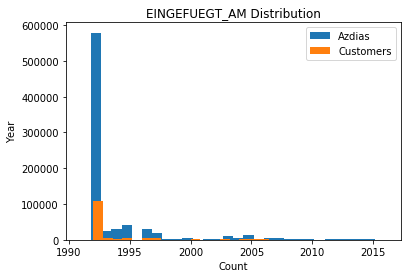

In [35]:
plt.hist(azdias["EINGEFUEGT_AM"], bins=30, label="Azdias")
plt.hist(customers["EINGEFUEGT_AM"], bins=30, label="Customers")
plt.ylabel("Year")
plt.xlabel("Count")
plt.title("EINGEFUEGT_AM Distribution")
plt.legend()
plt.show()

Seems like the distributions are almost similar. And the people who are registered in years before 1995 are more likely to be customers according to above graph.

We can further analyse and change other categorical columns after making sure all the unkown values are replaced with NaNs in the dataframes.

In [36]:
# unkown_attributes_values = attributes_values[(attributes_values["Meaning"] == "unknown") | ("no" in attributes_values["Meaning"])]

unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
print(len(unkown_attributes_values))

232


We have **232** columns which have unkown values.

In [37]:
unkown_attributes_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown
647,EWDICHTE,density of inhabitants per square kilometer,-1,unknown


In [38]:
def get_unkown_repr(attrib, unkown_attributes_values):
    """Returns the representation of unkown values"""
    
    unkown = unkown_attributes_values[unkown_attributes_values["Attribute"] == attrib]["Value"]
    unkown = unkown.astype(str).str.cat(sep=",")
    unkown = [int(x) for x in unkown.split(",")]
      
    return [unkown]

In [39]:
ager_typ_unkwon = get_unkown_repr("AGER_TYP", unkown_attributes_values)

print(ager_typ_unkwon)

[[-1]]


lets have a look at azdias dataframe before replacing all the 'unkown' values. 

In [40]:
azdias.head(15)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,15.0
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,21.0
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,3.0
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4,NaN
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,32.0
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1,8.0
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2,2.0
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1,5.0
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3,10.0
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3,4.0


Looking at second column `AGER_TYP` there are a lot of *-1*s which correspond to **unkown** values. To convert all these values into `np.nan` values we first have to get the **value** which corresponds to unkown value from the `attribute_value` data and then replace these values. 

In [41]:
def replace_unkown_with_nan(val, unkown):
    """Replaces unkown values with np.nan values if the value mathes with the unkown representation"""
    if val in unkown:
        return np.nan
    else:
        return val

In [42]:
azdias["AGER_TYP"] = azdias["AGER_TYP"].apply(replace_unkown_with_nan, args=(ager_typ_unkwon))

In [43]:
azdias.head(15)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,15.0
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,21.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4,NaN
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,32.0
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1,8.0
6,910248,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2,2.0
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1,5.0
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3,10.0
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3,4.0


We can repeat the same thing for all the 232 columns with unkwon values.

In [44]:
def replace_unkowns(df, unkown_attributes_values, verbose=False):
    """
    Replaces unkown values to 'np.nan' in all the columns provided in unkown_attributes_values list.
    """
    for attrib in unkown_attributes_values.Attribute:
        unkown = get_unkown_repr(attrib, unkown_attributes_values)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unkown, attrib))
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(replace_unkown_with_nan, args=(unkown))
    return df

In [45]:
azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_70
Replacing [[-1]] to NaN in Attribute KBA13_KW_61_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_80
Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Repl

In [46]:
customers = replace_unkowns(customers, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_61_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_80
Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Replacing [[-1]] to NaN in Attribute KBA13_SEG_MINIVA

### Missing values

Now that we have replaced all the unkowns to np.nan's we can now look at how many missing values each column contains and decide whether to keep a column for further analysis.

#### Missing values Column-wise

In [47]:
def get_missing_report(df):
    """
    Takes in a dataframe and returns a dataframe with information about column-wise missing values percentages.
    """
    missing_percen = df.isna().sum() * 100/ len(df)
    
    missing_percen_df = pd.DataFrame({"Attribute": df.columns,
                                     "Missing_Percentage": missing_percen}).reset_index(drop=True)
    return missing_percen_df

In [48]:
customer_missing_report = get_missing_report(customers)
azdias_missing_report = get_missing_report(azdias)

In [49]:
print("Total No of columns in Customers - ", len(customers.columns))
print("No of columns with missing values in customers - ",
      len(customer_missing_report[customer_missing_report.Missing_Percentage > 0]))

print("Total No of columns in Azdias - ", len(azdias.columns))
print("No of columns with missing values in azdias - ",
      len(azdias_missing_report[azdias_missing_report.Missing_Percentage > 0]))

Total No of columns in Customers -  370
No of columns with missing values in customers -  280
Total No of columns in Azdias -  367
No of columns with missing values in azdias -  280


In [50]:
def plot_percentage_missing(df1, df2, percentage=0, figsize=(10,70)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    fig.suptitle("Missing Data percentages")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df1[df1.Missing_Percentage>percentage], ax= ax)

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df2[df2.Missing_Percentage>percentage], ax= ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    # fig.tight_layout()
    plt.show()

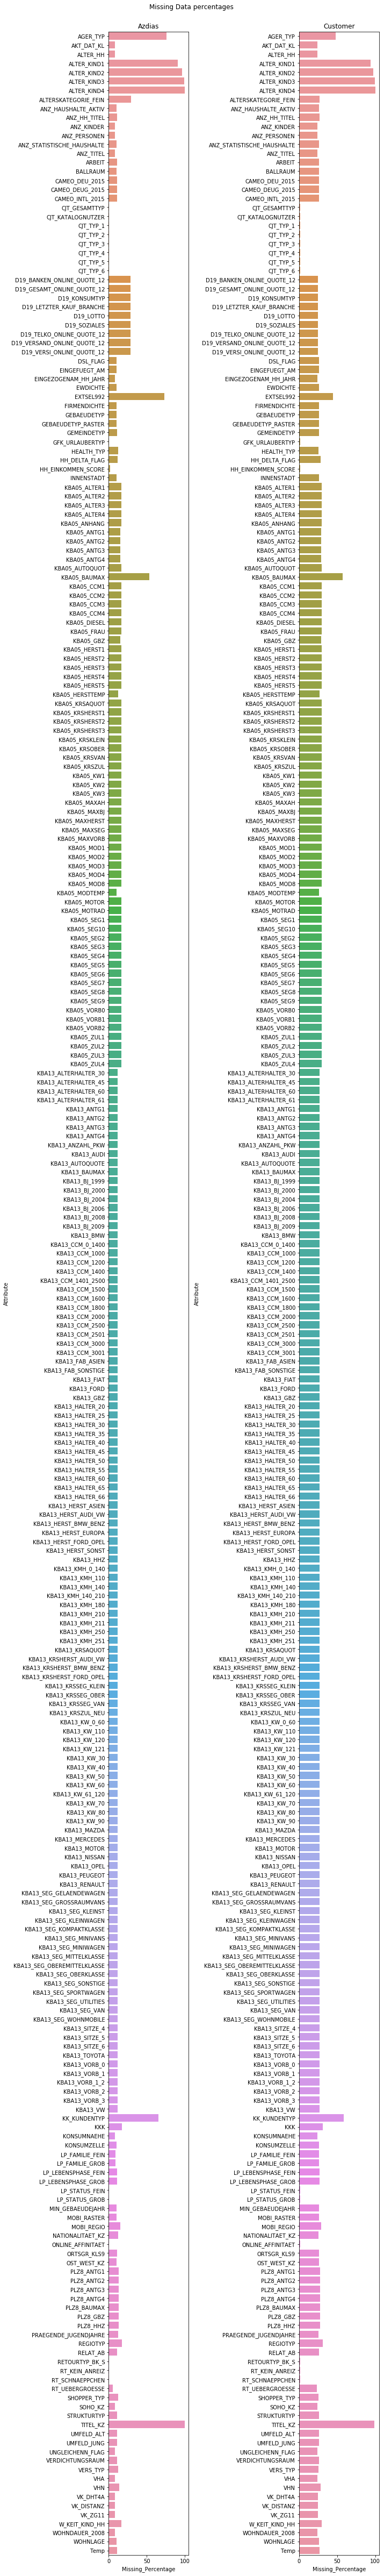

In [51]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=0)

* By looking at the plot above we can conclude what percentage of data is missing from each column where we have missing data. 
* There is overlap in both **Azdias** and **Customers** data i.e. data is missing from same columns.
* Also the percentage of missing values in **Azdias** and **Customers** coincide a lot, which confirms that customers data is a subset of azdias data.

We can threshold the missing percentage and see how many columns have missing data percentage more than the threshold.

**Note**:
 After testing multiple values of threshold 30 seems to be giving good results in terms of less columns to be removed and almost same number of columns to be removed from both dataframes.

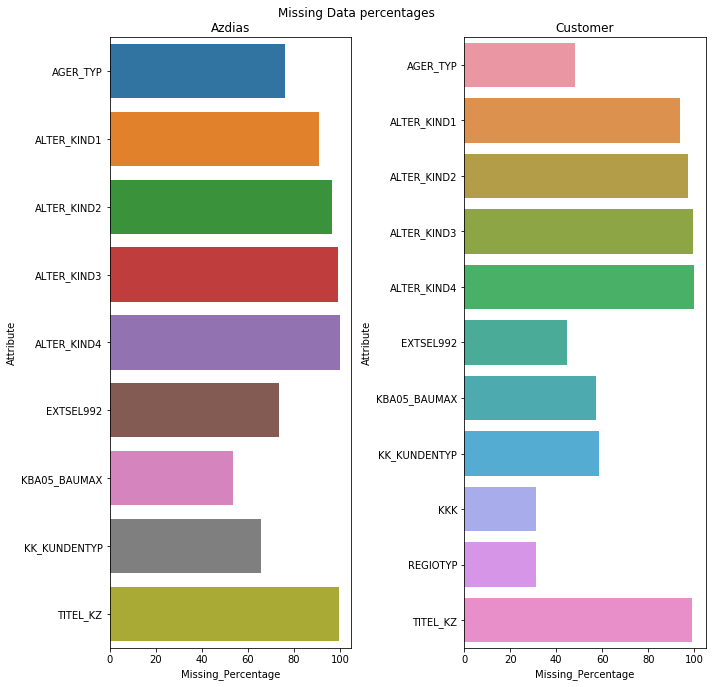

In [52]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=30, figsize=(10, 10))

* We have *11* features with more more than 30% missing values in **Customer** data, where as in **Azdias** data we only have *9* feature. Whereas, in total we had *279* columns with missing values in both dataframes. 
* So *11* and *9* are considerably less nuzmber of features when compared to *279* and we can drop them. 

We are going to remove the features with more than 30% of data from **Customer** data, also the same features have to be removed from **Azdias** data.

In [53]:
def remove_columns(df, remove_cols):
    """
    Drops given list of columns from df.
    """
    df = df.drop(remove_cols, axis = 1)
    return df

def remove_missing_columns(df1, df2, df1_missing, df2_missing, threshold=30):
    """
    Drops columns from df1 and df2 with given threshold.
    
    Uses df1_missing and df2_missing to determing which columns to remove.
    If df1_missing has more missing columns (missing_percentage > threshold),
    then df1_missing is taken as reference and vice versa.
    """
    
    removable_cols1 = df1_missing[df1_missing.Missing_Percentage > threshold]
    removable_cols2 = df2_missing[df2_missing.Missing_Percentage > threshold]
    
    if len(removable_cols1) > len(removable_cols2):
        remove_cols = removable_cols1.Attribute.tolist()
    else:
        remove_cols = removable_cols2.Attribute.tolist()
         
    df1 = remove_columns(df1, remove_cols)
    df2 = remove_columns(df2, remove_cols)
    print(f"\t\tRemoved {len(remove_cols)} columns from given dataframes")
    
    return (df1, df2, remove_cols)

In [54]:
print("Number of columns Before dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

azdias, customers, removed_cols = remove_missing_columns(azdias, customers, customer_missing_report, azdias_missing_report)

print("Number of columns After dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Number of columns Before dropping
Azdias - 367
Customers - 370
		Removed 11 columns from given dataframes
Number of columns After dropping
Azdias - 356
Customers - 359


#### Missing values Row-wise

After removing the columns which have more than 30% missing values, now we can look at the dataframes with remaining features for any missing values in rows.

In [55]:
def plot_missing_rowwise_histogram(df1, df2, bins=30, figsize=(10,6)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("No. of Rows vs No. of Missing features")
    ax.set_xlabel("No. of Missing Features")
    ax.set_ylabel("No. of Rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()

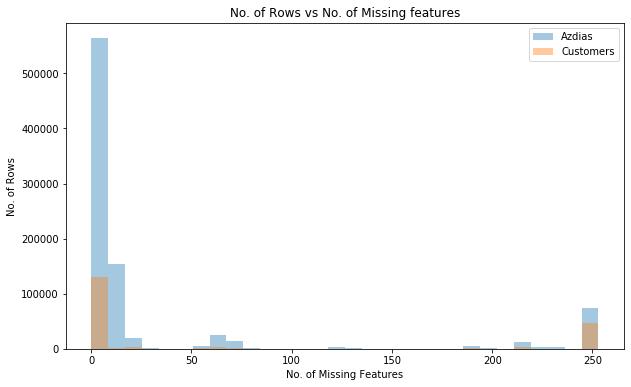

In [56]:
plot_missing_rowwise_histogram(azdias, customers)

From the above plot we can conclude,
* We have *250/355* features missing in approximately *70000* rows in **Azdias** and approximately *50000* rows in **Customers** data.
* Most of the rows have less than 50 missing values in both dataframes.
* **Customers** data has comparatively more missving rows than **Azdias**.

Now we can drop all the rows which have more than 50 missing values.

In [57]:
def remove_missing_rows(df, threshold, name=""):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
    
    print(f"\t\tRemoved {removed_rows} rows from {name} dataframe")
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [58]:
print("Number of rows Before dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

customers = remove_missing_rows(customers, threshold=50)
azdias = remove_missing_rows(azdias, threshold=50)

print("Number of rows After dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

Number of rows Before dropping
Azdias - 891221
Customers - 191652
		Removed 57406 rows from  dataframe
		Removed 153933 rows from  dataframe
Number of rows After dropping
Azdias - 737288
Customers - 134246


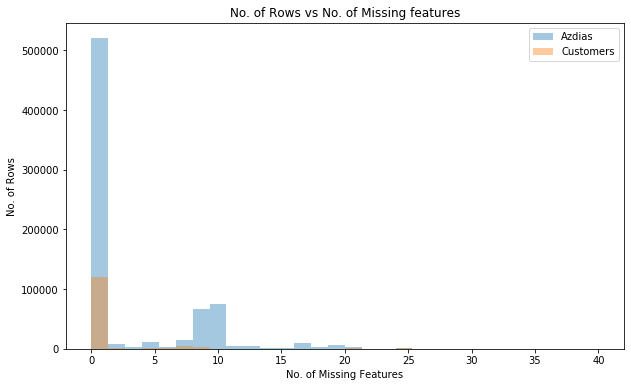

In [59]:
plot_missing_rowwise_histogram(azdias, customers)

As seen in the above plot we have successfully removed all the rows having more than 50 missing features. But, we still have some missing values in range of *1* to *50*. We can impute most common values of corresponding features in these rows, as the data represents the demographics of population. We can make an assumption that these missing values will be equal to the most common ones.



In [60]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737288 entries, 0 to 737287
Columns: 356 entries, LNR to Temp
dtypes: float64(266), int64(87), object(3)
memory usage: 2.0+ GB


In [61]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134246 entries, 0 to 134245
Columns: 359 entries, LNR to Temp
dtypes: float64(266), int64(88), object(5)
memory usage: 367.7+ MB


In [62]:
azdias_object_cols = azdias.columns[azdias.dtypes == "object"]
customer_object_cols = customers.columns[customers.dtypes == "object"]

In [63]:
print("Azdias columns with dtype Object \n",azdias_object_cols.values)
print("Azdias columns with dtype Object \n",customer_object_cols.values)

Azdias columns with dtype Object 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ']
Azdias columns with dtype Object 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ' 'PRODUCT_GROUP'
 'CUSTOMER_GROUP']


In [64]:
for col in azdias_object_cols:
    print("\nColumn ",col)
    print(azdias[col].value_counts())


Column  CAMEO_DEU_2015
6B    54006
8A    50776
4C    43988
2D    32906
7A    32630
3C    32565
3D    32176
8B    31262
4A    30254
8C    30147
9D    26746
9B    25888
7B    22921
9C    22919
9A    20057
2C    17742
8D    16675
6E    15598
5D    14071
2B    14042
6C    13868
2A    11921
1D    11457
1A    10167
5A     9721
5B     9691
5C     9050
4B     8284
7C     8127
4D     8051
6A     6416
3A     5871
6D     5756
3B     5709
6F     5048
4E     5005
1E     4783
7D     4431
7E     4375
1C     4012
5F     3939
9E     3841
1B     3815
5E     3241
XX      284
Name: CAMEO_DEU_2015, dtype: int64

Column  D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT             179081
D19_VERSICHERUNGEN         52220
D19_SONSTIGE               40546
D19_VOLLSORTIMENT          31292
D19_SCHUHE                 28486
D19_BUCH_CD                25643
D19_VERSAND_REST           23398
D19_DROGERIEARTIKEL        21371
D19_BANKEN_DIREKT          20993
D19_BEKLEIDUNG_REST        19147
D19_HAUS_DEKO              18823
D19_

The columns 

* *OST_WEST_KZ* - contains information about the history of the person i.e. which part of Germany they belonged to before unification. We can encode values in this column with pd_dummies or a label encoder.

The columns that can be removed:

* *D19_LETZTER_KAUF_BRANCHE* - contains information about the last branch they made a purchase.
* *CAMEO_DEU_2015* - Gives information about specific group a person belongs to.

These, columns have too much granularity in information they represent. This will increase the number of features for modeling purposes. So these columns can also be dropped for simplicity.


Removing the above specified cols. This is done by the function *remove_cols* which takes in the colums to be removed as a list already has the specified columns as a list.

In [65]:
remove_extra_cols = ["D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]

azdias = remove_columns(azdias, remove_extra_cols)
customers = remove_columns(customers, remove_extra_cols)

Encoding *OST_WEST_KZ* column.

In [66]:
def fix_ost_west_col(df):
    """
    Function to label encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    return df

In [67]:
azdias = fix_ost_west_col(azdias)
customers = fix_ost_west_col(customers)

Ecoding *ANREDE_KZ* column.

In [68]:
def fix_anrede_col(df):
    """
    Function to label encode the feature "ANREDE_KZ"
    """
    df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})
    
    return df

In [69]:
azdias = fix_anrede_col(azdias)
customers = fix_anrede_col(customers)

Encoding *CAMEO_INTL_2015* column, since it contains two types of information contained into one column. It can be further divided into two seperate columns. 

In [70]:
azdias['CAMEO_INTL_2015'].unique()

array([51., 24., 12., 43., 54., 22., 14., 13., 15., 41., 34., 55., 33.,
       25., nan, 23., 31., 52., 45., 35., 44., 32.])

In [71]:
def fix_cameo_intl_col(df):
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    return df

In [72]:
azdias = fix_cameo_intl_col(azdias)
customers = fix_cameo_intl_col(customers)

In [73]:
azdias['CAMEO_INTL_2015_FAMILY'].unique()

array([ 1.,  4.,  2.,  3.,  5., nan])

In [74]:
azdias['CAMEO_INTL_2015_WEALTH'].unique()

array([ 5.,  2.,  1.,  4.,  3., nan])

The column *WOHNLAGE* contains value - 0 for - no score calculated, while all other values represent some score. This value can be replaced with NaN.

In [75]:
azdias.WOHNLAGE.value_counts()

3.0    235402
7.0    161356
4.0    127406
2.0     94544
5.0     67924
1.0     41440
8.0      9199
0.0        17
Name: WOHNLAGE, dtype: int64

In [76]:
def fix_wohnlage_col(df):
    """
    Function to remove '0' from "WOHNLAGE" 
    """
    df["WOHNLAGE"] = df["WOHNLAGE"].replace({0: np.nan})
    
    return df

In [77]:
azdias = fix_wohnlage_col(azdias)
customers = fix_wohnlage_col(customers)

In [78]:
azdias.WOHNLAGE.value_counts(), azdias.WOHNLAGE.isna().sum()

(3.0    235402
 7.0    161356
 4.0    127406
 2.0     94544
 5.0     67924
 1.0     41440
 8.0      9199
 Name: WOHNLAGE, dtype: int64,
 17)

Seperating customers dataframe into two parts, i.e. taking out the extra columns present in customers dataset as a separate dataframe.

In [79]:
customer_extra_cols = customers[extra_cols_in_customers]
customers = customers.drop(extra_cols_in_customers, axis = 1)

In [80]:
customer_extra_cols.head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,COSMETIC_AND_FOOD,MULTI_BUYER,0
2,COSMETIC,MULTI_BUYER,0
3,FOOD,MULTI_BUYER,0
4,COSMETIC_AND_FOOD,MULTI_BUYER,0


Finally checking the shapes of all the dataframes.

In [81]:
azdias.shape, customers.shape, customer_extra_cols.shape

((737288, 353), (134246, 353), (134246, 3))

### Imputing missing values

Although we dropped columns and rows with missing values based on some threshold. We still have some columns having missing values. We can now address these missing values by either filling them with the mean of the values or most common values.

In this case, imputing missing values with most common values will make sense as this is demographic data and the values that are most common represent the population.

In [82]:
#azdias.isna().sum()

In [83]:
#customers.isna().sum()

In [84]:
customer_extra_cols.isna().sum()

PRODUCT_GROUP      0
CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
dtype: int64

We will fit the imputer on the azdias data, since the Azdias data represents the whole population and then transform both azdias and customers data.

In [85]:
imputer = SimpleImputer(strategy="most_frequent")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [ ]:
azdias.shape, customers.shape, customer_extra_cols.shape

#### Data Cleaning function

We can combine all the steps we did above into one single function and then proceed to further steps. The *clean_data* function in *data_utils* combines all the steps above, we can load the uncleaned data once again and use this function to clean the data and verify if the function is working.

In [86]:
azdias, customers, customers_additional, attributes_values, attributes_info = load_avarto_data()

Loading Raw Azdias and Customers Data


C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [87]:
def clean_data(azdias, customers, attributes_values, column_miss_perc=30, row_miss_count=50):
    
    print("Cleaning Given Dataframes")
    
    start = time.time()
    
    cleaning_info = {}
    
    extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
    
    # Forward fill attribute_values dataframe, to access required columns and corresponding info
    attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(azdias.columns[18:20])
    
    # Ignore if these cols are already cleaned 
    if not (customers[warning_cols[0]].dtype == 'float64') & (customers[warning_cols[1]].dtype == 'float64'):
        customers = fix_cameo_cols(customers)
    if not (azdias[warning_cols[0]].dtype == 'float64') & (azdias[warning_cols[1]].dtype == 'float64'):
        azdias = fix_cameo_cols(azdias)
        
        
    print("\tFixing LP_* columns")
    customers = fix_LP_cols(customers)
    azdias = fix_LP_cols(azdias)
    
    print("\tFixing EINGEFUGT column")
    customers = fix_eigefugt_col(customers)
    azdias = fix_eigefugt_col(azdias)
    
    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
    unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
    
    azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=False)
    customers = replace_unkowns(customers, unkown_attributes_values, verbose=False)
    
    # Missing Values
    
    # Columns with missing values
    print(f"\tRemoving columns with more than {column_miss_perc} % missing values")
    customer_missing_report = get_missing_report(customers)
    azdias_missing_report = get_missing_report(azdias)
    
    azdias, customers, removed_cols = remove_missing_columns(azdias, customers, 
                                               customer_missing_report,
                                               azdias_missing_report,
                                              threshold=column_miss_perc)
    
    
    
    # Rows with missing values
    print(f"\tRemoving rows with more than {row_miss_count} missing values")
    customers = remove_missing_rows(customers, threshold=row_miss_count, name="Customers")
    azdias = remove_missing_rows(azdias, threshold=row_miss_count, name="Azdias")
    
    
    # Columns with no relevant information of which are too granular
    print("\tRemoving unwanted Columns")
    remove_extra_cols = ["D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]
    removed_cols += remove_extra_cols
         
    azdias = remove_columns(azdias, remove_extra_cols)
    customers = remove_columns(customers, remove_extra_cols)
    
    # Encoding OST_WEST_KZ col
    print("\tEncoding OST_WEST_KZ column")
    azdias = fix_ost_west_col(azdias)
    customers = fix_ost_west_col(customers)
    
    print("\tEncoding ANREDE Column")
    azdias = fix_anrede_col(azdias)
    customers = fix_anrede_col(customers)
    
    print("\tEncoding CAMEO_INT column")
    azdias = fix_cameo_intl_col(azdias)
    customers = fix_cameo_intl_col(customers)
    
    print("\tEncoding WOHNLAGE column")
    azdias = fix_wohnlage_col(azdias)
    customers = fix_wohnlage_col(customers)
    
    # Separating customers dataset
    customers_additional = customers[extra_cols_in_customers]
    customers = customers.drop(extra_cols_in_customers, axis = 1)
        
    
    # Imputing Missing data
    print("\tImputing missing values with most frequent ones")
    imputer = SimpleImputer(strategy="most_frequent")

    azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
    customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)
    
    
    cleaning_info["Removed_cols"] = removed_cols   
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return azdias, customers, customers_additional, cleaning_info

In [ ]:
%%time
azdias, customers, customers_additional, cleaning_info = clean_data(azdias, customers, attributes_values)

Cleaning Given Dataframes
	Fixing 18, 19 columns
	Fixing LP_* columns
\Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'


In [ ]:
azdias.shape, customers.shape, customers_additional.shape

Saving cleaned dataframes to load them directly again.

In [72]:
azdias.to_csv('./data/Azdias_cleaned.csv', index=False)
customers.to_csv('./data/Customers_cleaned.csv', index=False)
customers_additional.to_csv('./data/Customer_Additional_cleaned.csv', index=False)

Checking if the dataframes are saved correctly by loading them and checking for sizes.

In [225]:
azdias, customers, customers_additional, attributes_values, attributes_info = load_avarto_data(clean=True)

Cleaned Data Exists
Loading Cleaned Azdias and Customers Data


In [226]:
azdias.shape, customers.shape, customers_additional.shape

((737288, 352), (134246, 352), (134246, 3))

### Feature Scaling

After cleaning the data, we can now scale the data to make sure all the features have the same range. We are going to use StandardScaler from sklearn to scale the data.

In [75]:
scaler = StandardScaler()

scaler.fit(azdias)

azdias = pd.DataFrame(scaler.transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [76]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.057636,1.262251,-1.430675,1.560767,0.186813,-0.125303,-0.299061,0.224688,0.335407,-0.06066,...,1.375841,0.694947,1.064908,1.454873,-0.747722,0.547826,-0.028542,1.141224,0.958448,-1.682098
1,1.057655,1.262251,0.801403,0.674377,0.120634,-0.125303,-0.299061,-0.634469,-0.031840,-0.06066,...,-0.355045,1.045322,0.450914,0.023979,-0.747722,0.547826,-1.083086,1.141224,0.958448,0.168026
2,1.057659,-0.934331,0.276209,-0.212013,-0.474979,-0.125303,-0.299061,-1.493626,-0.399086,-0.06066,...,-2.085931,0.344571,0.757911,1.812596,0.952074,0.547826,1.553275,-0.279664,0.958448,1.093087
3,1.057717,-0.934331,1.195299,0.009584,-0.342620,-0.125303,-0.299061,1.943002,-0.325637,-0.06066,...,-0.355045,-1.056931,-0.777072,-0.691468,-1.314321,0.547826,-0.555814,0.430780,-1.043354,0.168026
4,1.057729,-0.934331,-0.117688,-0.876806,-0.210262,-0.125303,-0.299061,-0.634469,-0.399086,-0.06066,...,-0.355045,1.395698,-0.163079,-0.691468,0.952074,0.547826,1.553275,0.430780,0.958448,-1.682098


In [77]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-2.436847,-0.934331,-0.117688,-0.876806,-0.474979,-0.125303,-0.299061,0.224688,-0.472535,-0.06066,...,0.510398,-0.356180,-1.391066,-1.406915,0.952074,0.547826,1.553275,-0.279664,-1.043354,1.093087
1,-1.915946,-0.934331,-0.642882,-3.092781,-0.474979,-0.125303,-0.299061,-0.634469,-0.472535,-0.06066,...,1.375841,1.395698,1.678901,1.812596,0.952074,0.547826,-1.083086,-0.279664,0.958448,1.093087
2,-1.915942,-0.934331,-0.380285,-1.320001,-0.541158,-0.125303,-0.299061,-1.493626,-0.472535,-0.06066,...,-0.355045,-0.005804,-1.084069,-1.406915,0.952074,0.547826,1.553275,-1.700552,-1.043354,1.093087
3,-1.915938,-0.934331,1.195299,0.009584,-0.077904,-0.125303,-0.299061,1.943002,-0.031840,-0.06066,...,1.375841,-1.056931,-0.777072,-0.691468,-1.314321,0.547826,-0.555814,-1.700552,-1.043354,0.168026
4,-1.915884,-0.934331,0.013611,-0.876806,-0.474979,-0.125303,-0.299061,0.224688,-0.472535,-0.06066,...,1.375841,-1.757682,-1.698063,-1.764638,0.952074,0.547826,-1.610359,-0.990108,-1.043354,0.168026


In [78]:
azdias.to_csv('./data/Azdias_scaled.csv', index=False)
customers.to_csv('./data/Customers_scaled.csv', index=False)

41

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Dimensionality reduction

As the number of features in the data is relatively high, we can verify the variance explained by each feature in the dataset. By using a dimensionality reduction technique, we can effectively reduce the number of features which do not vary much in the data. Since we cannot go through each and every feature ourselves to decide if the feature is varying, we can use a statistical approach to find how much variance is explained by each feature. One such algorithm is Principal Component Analysis(PCA). 



In [79]:
pd.set_option("display.max_colwidth", 200)

In [80]:
azdias, customers, customers_additional, attributes_values, attributes_info = load_avarto_data(scaled=True)

Scaled Data Exists
Loading Scaled Azdias and Customers Data


In [81]:
def perform_pca(data, n_components=None):
    pca = PCA(n_components, random_state=SEED)
    pca.fit(data)
    data_transformed = pca.transform(data)
    return pca, data_transformed

In [82]:
pca_azdias, _ = perform_pca(azdias, None)

In [83]:
def plot_pca_exp_variance(pca_azdias, cumulative=True, figsize=(8,10)):
    """
    Takes in two PCA models (which are fit on corresponding data) and plots 
    their Explained Variance vs Number of components
    
    """   
    
    if cumulative:
        azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
        y_label = "Percentage Explained Variance"
    else:
        azdias_variance = pca_azdias.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(azdias_variance)
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Azdias - PCA Explained Variance Ratio vs Number of Components")
    ax.grid()
    plt.show()

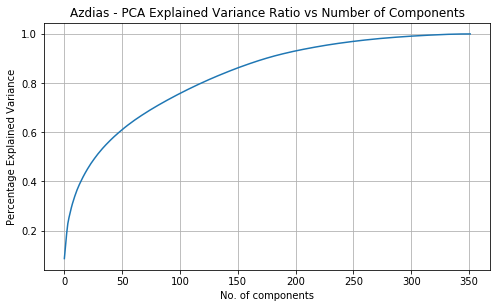

In [84]:
plot_pca_exp_variance(pca_azdias)

From the explained variance plot it is observed that around 150 components explain 90% of variance in the dataset. We can set the number of components to 150 and perform PCA analysis to have 150 compinents. Then we can see the feature importances for each component, to understand what each PCA component represents. 


In [85]:
pca_150, azdias_pca_150 = perform_pca(azdias, n_components=150)

### Interpreting PCA components

We can now look at the feature weights given by the PCA algorithm and understand what each component is comprised of. We can write a function to get information about the top n positive features and top n negative features for a given component.

In [86]:
def plot_feature_weights(df, pca, attributes_info, dimension, n_weights = 5, plot=True,figsize=(7,8)):
    """
    This function displays interesting features of the selected dimension
    """
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in attributes_info.Attribute.values:
            feat_descs.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False, ignore_index=True)
           
    if plot:
        fig = plt.figure(figsize=figsize)

        ax = fig.add_subplot(211)
        ax.bar(feat_names, feat_weights)
        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
    return component_info

### Component 0

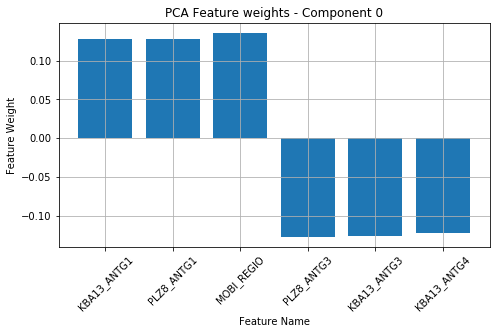

,Feature,Description,FeatureWeight
0,MOBI_REGIO,moving patterns,0.135125
1,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.127788
2,KBA13_ANTG1,No description given,0.127174
3,KBA13_ANTG4,No description given,-0.122200
4,KBA13_ANTG3,No description given,-0.126025
5,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.126683


In [87]:
component_0_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 0, 3)
component_0_info.head(10)

**Component 0** 
* Has a high positive weight to moving patterns of people.
* Has a high weight to number of 1-2 family houses in the neighbourhood and a negative weight to number of 6-10 family houses.
* KBA13_* - this feature has no description given (in Attributes - levels data), but some similar features (which have a description) correspond to shares of cars with some specification. 

### Component 1

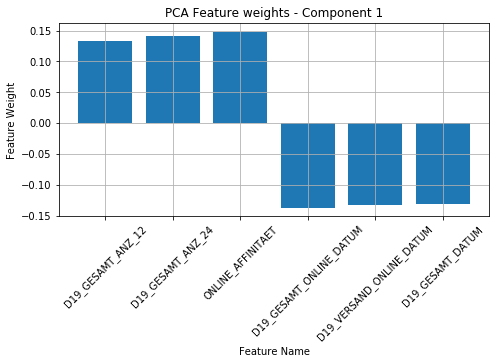

,Feature,Description,FeatureWeight
0,ONLINE_AFFINITAET,online affinity,0.148410
1,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24 months,0.141723
2,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12 months,0.133765
3,D19_GESAMT_DATUM,actuality of the last transaction with the complete file TOTAL,-0.131491
4,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the segment mail-order ONLINE,-0.132221
5,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the complete file ONLINE,-0.137122


In [88]:
component_1_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 1, 3)
component_1_info.head(10)

**Component 1** 
* Has a high positive weights towards features describing online activity and transactions of last 12 and 24 months.
* Has a negative weight to features containing information about when was the last transaction made.

### Component 2

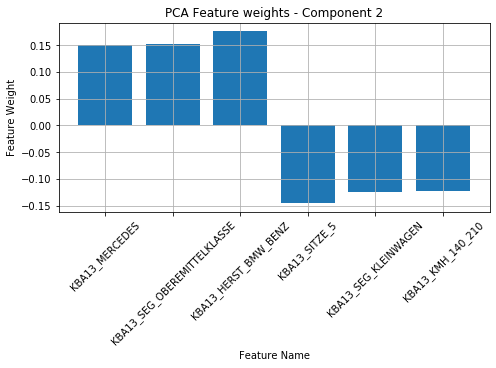

,Feature,Description,FeatureWeight
0,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.175969
1,KBA13_SEG_OBEREMITTELKLASSE,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)",0.152740
2,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.150043
3,KBA13_KMH_140_210,share of cars with max speed between 140 and 210 km/h within the PLZ8,-0.122527
4,KBA13_SEG_KLEINWAGEN,"share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8",-0.124400
5,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.145784


In [89]:
component_2_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 2, 3)
component_2_info.head(10)

**Component 2** 
* Has a high positive weights towards features that have information about upper class car's shares.
* Has a negative weight to features that have information about lower class cars's share.

### Component 3

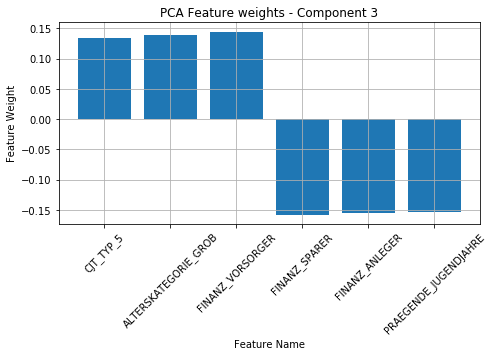

,Feature,Description,FeatureWeight
0,FINANZ_VORSORGER,financial typology: be prepared,0.144806
1,ALTERSKATEGORIE_GROB,age through prename analysis,0.139258
2,CJT_TYP_5,No description given,0.134903
3,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (avantgarde or mainstream),-0.153875
4,FINANZ_ANLEGER,financial typology: investor,-0.155575
5,FINANZ_SPARER,financial typology: money saver,-0.157590


In [90]:
component_3_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 3, 3)
component_3_info.head(10)

**Component 3** 
* This component corresponds to people who are always financially prepared.
* This component has a negative weight to people who save money or invest money.
* Also the age determined through prename analysis has a big impact on this component.
* The movement a person witnessed/participated during their youth has a negative weight on this component.

### Component 4

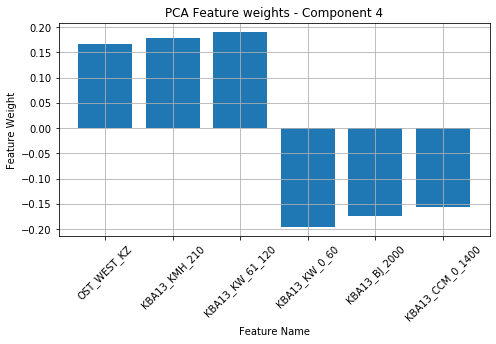

,Feature,Description,FeatureWeight
0,KBA13_KW_61_120,share of cars with an engine power between 61 and 120 KW - PLZ8,0.189727
1,KBA13_KMH_210,No description given,0.177768
2,OST_WEST_KZ,flag indicating the former GDR/FRG,0.167366
3,KBA13_CCM_0_1400,share of cars with less than 1401ccm within the PLZ8,-0.156339
4,KBA13_BJ_2000,share of cars built between 2000 and 2003 within the PLZ8,-0.173307
5,KBA13_KW_0_60,share of cars with less than 61 KW engine power - PLZ8,-0.194690


In [91]:
component_4_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 4, 3)
component_4_info.head(10)

**Component 4** 
* People with share of cars with less than 61KW engine has highest negative weight and cars with engine power between 61 and 120KW has highest positive weight.
* The origins of the person i.e. where they belonged before German unification is also having a positive weight.
* Some other car specifications are playing an impact on this component.

We can further look into all the 150 components that PCA has and analyse what each component represents.

## Customer Segmentation - K-Means Clustering

After reducing the number of dimensions, we will now use the K-Means Clustering algorithm to cluster the general population into different segments.

In [93]:
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        
        kmeans = KMeans(n, random_state=SEED)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

In [94]:
%%time
scores, range_ = get_Kmeans_scores(azdias_pca_150, 2, 20, 1)

Performing K-Means clustering
Given range min:2, max:20, step:1

Training for n_clusters:  2
Done! Score:  206818783.6999809
Time elapsed: 62.55 sec.

Training for n_clusters:  3
Done! Score:  199029554.25093153
Time elapsed: 95.06 sec.

Training for n_clusters:  4
Done! Score:  194535773.68052715
Time elapsed: 123.60 sec.

Training for n_clusters:  5
Done! Score:  190900830.21783048
Time elapsed: 147.21 sec.

Training for n_clusters:  6
Done! Score:  188127292.55989274
Time elapsed: 203.86 sec.

Training for n_clusters:  7
Done! Score:  185654395.6833167
Time elapsed: 325.72 sec.

Training for n_clusters:  8
Done! Score:  183555457.24332973
Time elapsed: 310.02 sec.

Training for n_clusters:  9
Done! Score:  181720016.10321704
Time elapsed: 353.98 sec.

Training for n_clusters:  10
Done! Score:  180371852.30484873
Time elapsed: 349.61 sec.

Training for n_clusters:  11
Done! Score:  179126138.94426203
Time elapsed: 563.76 sec.

Training for n_clusters:  12
Done! Score:  178071215.0754

In [95]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="orange")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()

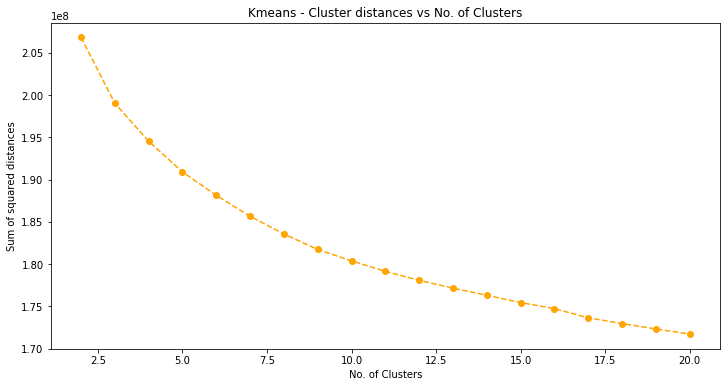

In [96]:
plot_elbow(scores, range_)

In [97]:
pca_200, azdias_pca_200 = perform_pca(azdias, n_components=200)

In [98]:
%%time
scores, range_ = get_Kmeans_scores(azdias_pca_200, 2, 20, 1)

Performing K-Means clustering
Given range min:2, max:20, step:1

Training for n_clusters:  2
Done! Score:  225238439.4483011
Time elapsed: 77.44 sec.

Training for n_clusters:  3
Done! Score:  217447143.04502672
Time elapsed: 107.19 sec.

Training for n_clusters:  4
Done! Score:  212951345.9223925
Time elapsed: 177.69 sec.

Training for n_clusters:  5
Done! Score:  209310102.32384628
Time elapsed: 203.62 sec.

Training for n_clusters:  6
Done! Score:  206533655.58076748
Time elapsed: 262.09 sec.

Training for n_clusters:  7
Done! Score:  204052785.97496518
Time elapsed: 351.28 sec.

Training for n_clusters:  8
Done! Score:  201953680.8209726
Time elapsed: 326.22 sec.

Training for n_clusters:  9
Done! Score:  200112009.11663356
Time elapsed: 422.75 sec.

Training for n_clusters:  10
Done! Score:  198759630.1646071
Time elapsed: 443.15 sec.

Training for n_clusters:  11
Done! Score:  197510054.11279607
Time elapsed: 677.92 sec.

Training for n_clusters:  12
Done! Score:  196426465.57326

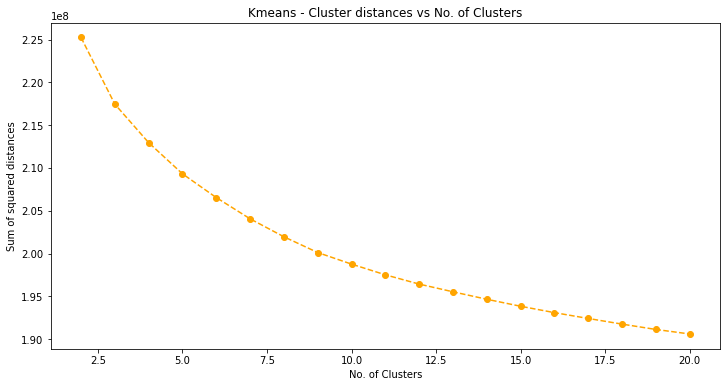

In [99]:
plot_elbow(scores, range_)

### EXPLAIN ABOUT choosing 150 components and Number of clusters selected

In [100]:
kmeans = KMeans(8, random_state=SEED)

kmeans.fit(azdias_pca_150)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)

In [101]:
azdias_clusters = kmeans.predict(azdias_pca_150)

In [102]:
customers_pca_150 = pca_150.transform(customers)

In [103]:
customers_clusters = kmeans.predict(customers_pca_150)

In [104]:
print(azdias_clusters[:15], "\n",customers_clusters[:15])

[0 0 1 5 1 0 0 7 7 2 0 0 7 3 0] 
 [1 2 1 5 7 6 7 2 6 6 6 2 6 6 6]


In [105]:
customers_clusters = pd.Series(customers_clusters)
azdias_clusters = pd.Series(azdias_clusters)

In [106]:
customers_clusters.value_counts().sort_index()

0     1232
1    40139
2    15827
3     2292
4     3688
5     4475
6    38621
7    27972
dtype: int64

In [107]:
azdias_clusters.value_counts().sort_index()

0    112342
1    115348
2     96221
3     89792
4     73055
5     65200
6    117569
7     67761
dtype: int64

Number of people coming under each cluster can be stored in a dataframe for further analysis.

In [108]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [109]:
cluster_info

,Cluster,Population,Customers
0,0,112342,1232
1,1,115348,40139
2,2,96221,15827
3,3,89792,2292
4,4,73055,3688
5,5,65200,4475
6,6,117569,38621
7,7,67761,27972


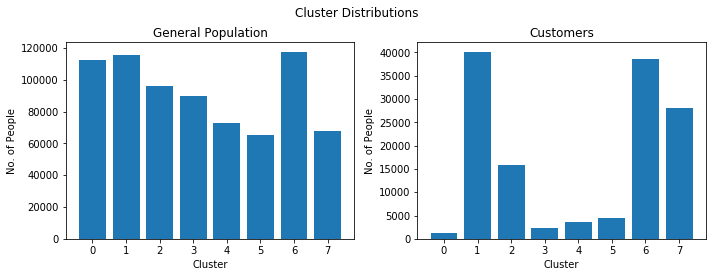

In [110]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

How much percentage of population under consideration is present in each cluster.

In [111]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)

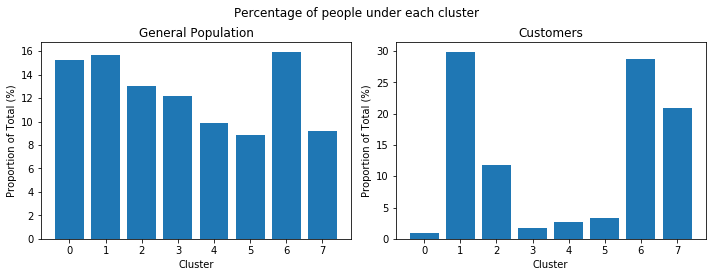

In [112]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Pop_proportion"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Cust_proportion"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
ax2.set_title("Customers")

fig.suptitle("Percentage of people under each cluster")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Ratio of customers proportion to general population proportion in each cluster. This gives an idea of which clusters are the customers of the mail order company from and where can the company acquire its new customers from. For example if the ratio of customers proportion to population proportion in one cluster is more than one. Then it is more likely that there is a chance that people from that cluster becoming future customers.

In [113]:
cluster_info["Cust_over_Pop"] = cluster_info["Cust_proportion"] / cluster_info["Pop_proportion"]

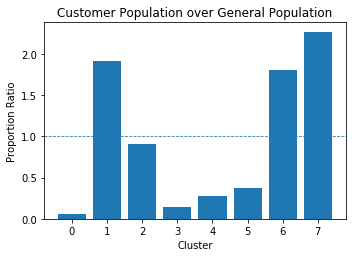

In [114]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.bar(cluster_info["Cluster"], cluster_info["Cust_over_Pop"])
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("Customer Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

What does each cluster represent?

To answer this we can see which pca component influences a given cluster most and then identifying which feature influences that pca component. This is done by the following function.

In [115]:
def explain_cluster(kmeans_model, cluster_no, data, pca_model, attributes_info, num_components=2, num_feat_per_comp=3):
    
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True, ignore_index=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, attributes_info, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos, ignore_index=True)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info

In [135]:
cluster_1 = explain_cluster(kmeans, 1, azdias, pca_150, attributes_info)
cluster_1

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,3.640148,MOBI_REGIO,moving patterns,0.135125
1,0,3.640148,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.127788
2,0,3.640148,KBA13_ANTG1,No description given,0.127174
3,0,3.640148,KBA13_ANTG4,No description given,-0.122200
4,0,3.640148,KBA13_ANTG3,No description given,-0.126025
5,0,3.640148,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.126683
6,11,0.416937,KBA13_ALTERHALTER_45,share of car owners between 31 and 45 within the PLZ8,0.158383
7,11,0.416937,KBA05_SEG9,share of vans in the microcell,0.150346
8,11,0.416937,KBA05_SEG10,"share of more specific cars (Vans, convertables, all-terrains, MUVs etc.)",0.144594
9,11,0.416937,LP_LEBENSPHASE_GROB,lifestage rough,-0.139926


In [136]:
cluster_6 = explain_cluster(kmeans, 6, azdias, pca_150, attributes_info)
cluster_6

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,7.813991,MOBI_REGIO,moving patterns,0.135125
1,0,7.813991,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.127788
2,0,7.813991,KBA13_ANTG1,No description given,0.127174
3,0,7.813991,KBA13_ANTG4,No description given,-0.122200
4,0,7.813991,KBA13_ANTG3,No description given,-0.126025
5,0,7.813991,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.126683
6,1,3.311160,ONLINE_AFFINITAET,online affinity,0.148410
7,1,3.311160,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24 months,0.141723
8,1,3.311160,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12 months,0.133765
9,1,3.311160,D19_GESAMT_DATUM,actuality of the last transaction with the complete file TOTAL,-0.131491


In [137]:
cluster_7 = explain_cluster(kmeans, 7, azdias, pca_150, attributes_info)
cluster_7

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,2,5.861804,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.175969
1,2,5.861804,KBA13_SEG_OBEREMITTELKLASSE,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)",0.152740
2,2,5.861804,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.150043
3,2,5.861804,KBA13_KMH_140_210,share of cars with max speed between 140 and 210 km/h within the PLZ8,-0.122527
4,2,5.861804,KBA13_SEG_KLEINWAGEN,"share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8",-0.124400
5,2,5.861804,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.145784
6,3,1.758108,FINANZ_VORSORGER,financial typology: be prepared,0.144806
7,3,1.758108,ALTERSKATEGORIE_GROB,age through prename analysis,0.139258
8,3,1.758108,CJT_TYP_5,No description given,0.134903
9,3,1.758108,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (avantgarde or mainstream),-0.153875


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [165]:
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv')

C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [166]:
mailout_train.shape

(42962, 367)

In [167]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


0    42430
1      532
Name: RESPONSE, dtype: int64


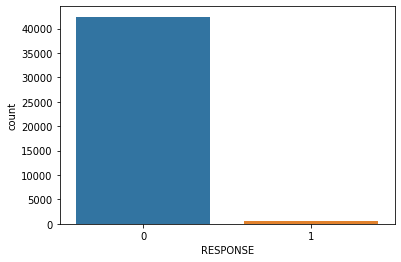

In [168]:
print(mailout_train.RESPONSE.value_counts())
sns.countplot("RESPONSE", data=mailout_train)

The data is highly imbalanced. We have more thn 40 thousand `0` responses and only 532 `1` responses. Accuracy will be a bad metric to choose for this problem since the accuracy might always be more than 98% even if the model predicts all zeros. Since `42430/(42430+532)*100 = 98.7 %`. So, even if the model predicts zero for all the data points we will end up with having accuracy 98.7% which does not make sense in this case.

To address this imbalance while evaluating the model we need to chose a metric which will take this class imbalance into accounts. The usual metrics used for imbalanced classification are *Precision and Recall* or *Area under Receiver Operating Curve (AUROC)*. 

Before understanding what these two metrics mean and how they are calculated we need to understand the basics of confusion matrix.

* Confusion Matrix: is a `2x2` matrix in case of binary classification problems which shows the number of values predicted correctly and the number of values predicted wrongly. The confusion matrix is the base for any classification metric, even accuracy can be calculated from the values inside confusion matrix.

Terms inside confusion matrix:
* **True Positive (TP)** -


# EXPLAIN HERE


https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba
https://towardsdatascience.com/metrics-for-imbalanced-classification-41c71549bbb5

* Precision and Recall

* AUROC 

In [169]:
def clean_data_for_supervised(cleaned_azdias, df, attributes_values):
    
    print("Cleaning Given Dataframe")
    
    start = time.time()
    
    # Forward fill attribute_values dataframe, to access required columns and corresponding info
    attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(df.columns[18:20])
    
    # Ignore if these cols are already cleaned 
    if not (df[warning_cols[0]].dtype == 'float64') & (df[warning_cols[1]].dtype == 'float64'):
        df = fix_cameo_cols(df)
    
    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
    unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
    
    df = replace_unkowns(df, unkown_attributes_values, verbose=False)
    
    
    # Dropping columns which are not in azdias
    print("\tDropping extra columns")
    cols_to_drop = [col for col in df.columns if col not in azdias.columns]
#     cols_to_drop += ["EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]
    
    df = remove_columns(df, cols_to_drop)
    
    
    # Encoding OST_WEST_KZ col
    print("\tEncoding OST_WEST_KZ column")
    df = fix_ost_west_col(df)
    
    # Imputing Missing data
    print("\tImputing missing values with most frequent ones")
    imputer = SimpleImputer(strategy="most_frequent")
    
    imputer.fit(azdias)
    df = pd.DataFrame(imputer.transform(df), columns = df.columns)
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return df

In [170]:
labels = mailout_train["RESPONSE"]

In [171]:
mailout_train = clean_data_for_supervised(azdias, mailout_train, attributes_values)

Cleaning Given Dataframe
	Fixing 18, 19 columns
	Replacing 'unkown' values with 'NaN'
	Dropping extra columns
	Encoding OST_WEST_KZ column
	Imputing missing values with most frequent ones
Completed Cleaning in 13.184732437133789 seconds


In [172]:
mailout_train.shape

(42962, 352)

In [173]:
azdias.shape

(737288, 352)

In [212]:

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Setting the benchmark

Training a Logistic regression model on unscaled and unspltt data to set a benchmark performance that we aim to improve upon.

In [175]:
lr = LogisticRegression(random_state=SEED)

In [176]:
lr.fit(mailout_train, labels)

C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [177]:
pred = lr.predict(mailout_train)

In [178]:
print("Baseline AUROC - ", roc_auc_score(labels, pred))

Baseline AUROC -  0.5


## Trying out different models

#### Scaling data

In [179]:
# scaler = StandardScaler()

mailout_train = pd.DataFrame(scaler.transform(mailout_train), columns = mailout_train.columns)

In [218]:
mailout_train_reduced = pca_150.transform(mailout_train)

#### Split dataset into train and test

In [195]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.3, random_state=SEED)

In [213]:
def classifier_roc(model, X_train, y_train, X_test, y_test, cv = 5):
    """
    Fit a classifier using GridSearchCV and calculates ROC AUC
    
    INPUT:
    - model (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - prints elapsed time and ROX AUC
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    
    start = time.time()
        
    scores = cross_val_score(model,X_train, y_train, scoring='roc_auc', cv=5)
    
    model = model.fit(X_train, y_train)
    
    print("Cross Validation Score: ",np.mean(scores))
    
    print(roc_auc_score(y_train, model.predict(X_train)))
    print(roc_auc_score(y_test, model.predict(X_test)))
    print(confusion_matrix(y_test, model.predict(X_test)))
    
    end = time.time()
    print(end-start)

In [214]:
lr = LogisticRegression(solver="saga", random_state=SEED)

classifier_roc(lr, X_train, y_train, X_val, y_val)

C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_

Cross Validation Score:  0.4746133575471285
0.5002498467703017
0.5018287473485742
[[12696    33]
 [  159     1]]
41.56984210014343


C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [215]:
dtc = DecisionTreeClassifier(random_state=SEED)

classifier_roc(dtc, X_train, y_train, X_val, y_val)

Cross Validation Score:  0.5119950991986002
1.0
0.5130369137402782
[[12504   225]
 [  153     7]]
8.651888132095337


In [216]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=SEED)
classifier_roc(rfc, X_train, y_train, X_val, y_val)

Cross Validation Score:  0.5563794511899545
1.0
0.4993322334825988
[[12712    17]
 [  160     0]]
33.68891668319702


In [217]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=SEED)
classifier_roc(gbc, X_train, y_train, X_val, y_val)

Cross Validation Score:  0.7538008782818411
0.5228494623655914
0.4998035980831173
[[12724     5]
 [  160     0]]
187.99225068092346


In [219]:
X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(mailout_train_reduced, labels, stratify=labels, test_size=0.3, random_state=SEED)

In [220]:
lr = LogisticRegression(solver="saga", random_state=SEED)

classifier_roc(lr, X_train_red, y_train_red, X_val_red, y_val_red)

C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_

Cross Validation Score:  0.47990315436602815
0.4986310695885479
0.4992362420457224
[[12630    99]
 [  159     1]]
19.040098905563354


C:\Users\namod001\Anaconda3\envs\Python3.7\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [221]:
dtc = DecisionTreeClassifier(random_state=SEED)

classifier_roc(dtc, X_train_red, y_train_red, X_val_red, y_val_red)

Cross Validation Score:  0.5008378340391471
1.0
0.4940905118233954
[[12499   230]
 [  159     1]]
75.64974975585938


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [134]:
# mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv')